In [1]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('_mpl-gallery')
import pandas as pd
import os
from matplotlib.colors import Normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import torch as T
import torch.linalg as LA
import os

In [2]:

class LID_processer:
    def __init__(self, LID_eval):
        self.LID_eval = T.tensor(LID_eval)
        self.grid = int(np.sqrt(LID_eval.shape[0]))
        
    @staticmethod
    def process_results(LID_eval, mode='TV', threshold=0.95):
        if mode == 'TV':
            # how many dimensions are needed to explain 95% of the variance    
            cumsum = T.cumsum(LID_eval, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1
        elif mode == 'MV':
            ## number of dimnesions larger than 5% of the variance
            print(LID_eval)
            LID_eval = (LID_eval >= (1-threshold)).sum(dim=1) 
            # print(LID_eval)
        elif mode == 'VR':
            ## compute the variance ratio
            delta_v = LID_eval[:, ] - T.concatenate((LID_eval[:, 1:], T.zeros((LID_eval.shape[0], 1))), dim=1)
            total_dv = T.sum(delta_v, dim=1)
            norm_delta_v = delta_v/total_dv.reshape(-1, 1)
            cumsum = T.cumsum(norm_delta_v, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1
            
        elif mode == 'percent':
            LID_eval = T.sum(LID_eval[:, :2], dim=1)
        else:
            raise ValueError('mode should be either dim or percent')
        return LID_eval           

    def plot_LID(self,  ax=None,  cmap='jet', mode='dim', threshold=0.95, prerun=False, range=None):
        LID_map = self.process_results(self.LID_eval, mode, threshold)
        LID_map = LID_map.reshape(self.grid, self.grid).to('cpu').numpy()

        map = np.flip(LID_map, axis=0)
        if prerun:
            return (map.min(), map.max())        

        if ax is None:
            # cbar of this plot
            if mode == 'percent':
                image = plt.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1)) 
                # continuous colorbar
                # plt.colorbar(image)
            else:
                self.discrete_matshow(map, cmap=cmap)

   
            # not show the ticks
            plt.xticks([])
            plt.yticks([])

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            if mode == 'percent':
                # continuous colorbar
                # image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                if range is not None:
                    image = ax.imshow(map, cmap=cmap, vmin=range[0], vmax=range[1])
                else:
                    image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                # plt.colorbar(image, ax=ax)
                average = np.mean(map)
                ax.text(0.8, 0.05, f'{average:.2f}', color='k', transform=ax.transAxes)
            else:
                # discrete colorbar
                if range is not None:
                    image = self.discrete_matshow(map, cmap=cmap, ax=ax, range=range)
                else:
                    image = self.discrete_matshow(map, cmap=cmap, ax=ax)
                average = np.mean(map)
                # ax.set_title(f'Average LID: {average:.2f}')
                ax.text(0.8, 0.05, f'{average:.2f}', color='w', transform=ax.transAxes)

        return image
        

    @staticmethod     
    def discrete_matshow(data, cmap, ax=None, range=None):
    # get discrete colormap
        if range is not None:
            cmap = plt.get_cmap(cmap, range[1] - range[0] + 1)
        else:
            cmap = plt.get_cmap(cmap, np.max(data) - np.min(data) + 1)
        # set limits .5 outside true range
        if ax is None:
            if range is not None:
                mat = plt.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = plt.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            # tell the colorbar to tick at integers
            cax = plt.colorbar(mat, ticks=np.arange(np.min(data), np.max(data) + 1))
        else:
            if range is not None:
                mat = ax.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = ax.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            
            # tell the colorbar to tick at integers
            fig = ax.get_figure()
            # cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            # plt.colorbar(mat,  ticks=np.arange(np.min(data), np.max(data) + 1))
            return mat
            
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y)) 



def plot_prob_map(labels, alpha, X_2d, y, ax=None, cmap=cm.tab10, epsilo=0.85, proba=True, ture_map=False, ):
    """Plot probability map for the classifier
    """

    n_class_max = max(labels)
    labels_normlized = labels/n_class_max
    map = cmap(labels_normlized)
    if proba:
        map[:, 3] = alpha 
    map[:, 3] *= epsilo  # plus a float to control the transparency
    grid = int(np.sqrt(labels.shape[0]))
    map =  map.reshape(grid, grid, 4)
    map = np.flip(map, 0)
    ax.imshow(map, interpolation='nearest', aspect='equal', extent=[0, 1, 0, 1])
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])
    # set lim
    # ax.set_xlim(xx.min(), xx.max())
    # ax.set_ylim(yy.min(), yy.max())
    X_2d_scaled = MinMaxScaler().fit_transform(X_2d)
    ax.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y, s=0.5, alpha=0.8, cmap=cmap)

    return ax

def plot_GM(D):
    gird = int(np.sqrt(D.shape[0]))
    D = D.reshape(gird, gird)
    D = np.flip(D, axis=0)
    plt.imshow(D, cmap='jet')

In [3]:
# def plot_LID(dir, threshold=0.99, title=None):
#     DBM = np.load(dir + 'DBM_orig_torch.npz')
#     SDBM = np.load(dir + 'SSNP.npz')
#     DV = np.load(dir + 'DeepView_0.65.npz')
#     proj_name = ['DBM', 'SDBM', 'DV']
#     proj = [DBM, SDBM, DV]
#     row_names = ['Decsion Map', 'Local Intrinsic Dimensionality\n Axes needed to explain 99% variance', 'variance explained by the first 2 PCs']

#     fig, axes = plt.subplots(3, 3, figsize=(9, 10))

#     row1_min, row1_max = 1, 0
#     row2_min, row2_max = 1, 0
#     for j, ax_col in enumerate(axes.T):
        
#         for i, ax in enumerate(ax_col):
#             if j == 0:
#                 ax.set_ylabel(row_names[i])
#             if i == 0:
#                 ax.set_title(proj_name[j])
            
#             if i == 0:
#                 ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
#             else:
#                 LID_holder = LID_processer(proj[j]['LID_evalues'])
#                 if i == 1:
#                     curmin, curmax=  LID_holder.plot_LID(ax=ax, mode='dim', threshold=threshold)
#                     row1_min = min(row1_min, curmin)
#                     row1_max = max(row1_max, curmax)
#                 elif i == 2:
#                     curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold)
#                     row2_min = min(row2_min, curmin)
#                     row2_max = max(row2_max, curmax)

#     ## set the same colorba

#     # plt.tight_layout()
#     fig.subplots_adjust(wspace=0.1, hspace=0.1)
#     if title is not None:
#         fig.suptitle(title, fontsize=16)
#     return fig
                


def plot_LID2(dir, threshold=0.95, title=None, mode1='MV'):
    DBM = np.load(dir + 'DBM.npz')
    SDBM = np.load(dir + 'SDBM.npz')
    DV = np.load(dir + 'DeepView.npz', allow_pickle=True)
    proj_name = ['DBM (UMAP+NNinv)', 'SDBM', 'DeepView']
    proj = [DBM, SDBM, DV]
    row_names = ['Decsion Map', 'Estimated ID', 'Percentage of variance \naccounted for by the first 2 PCs', ]

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    minmax = {'row1': [2, 1], 'row2': [2, 1], 'row3': [2, 1], 'row4': [1, 0], 'row5': [1, 0], 'row6': [1, 0]}
    for j, ax_col in enumerate(axes.T):
        for i, ax in enumerate(ax_col):
            if i == 0:
                # ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
                pass
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])
                if i == 1:
                    curmin, curmax =  LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, prerun=True)
                    # update the minmax
                    minmax[f'row{i}'][0] = min(minmax[f'row{i}'][0], curmin)
                    minmax[f'row{i}'][1] = max(minmax[f'row{i}'][1], curmax)
                elif i == 2:
                    curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, prerun=True)
                    minmax[f'row{i}'][0] = min(minmax[f'row{i}'][0], curmin)
                    minmax[f'row{i}'][1] = max(minmax[f'row{i}'][1], curmax)

    
    for j, ax_col in enumerate(axes.T):
        for i, ax in enumerate(ax_col):
            if j == 0:
                ax.set_ylabel(row_names[i], rotation=90, ha='center', va='center')
                ax.yaxis.set_label_coords(-0.1, 0.5)
            if i == 0:
                ax.set_title(proj_name[j])
            
            if i == 0:
                ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])

                if i == 2:

                    ax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, range=minmax[f'row{i}'])

                    if j == len(proj) - 1:
                        norm = colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1])

                        # print(minmax[f'row{i}'][0], minmax[f'row{i}'][1])
                        # cbar_dbm = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1]), cmap='cividis'), ax=axes[i,:], orientation='vertical', shrink=0.9, aspect=20, pad=0.3, location='right')

                        # cbar_dbm.ax.tick_params(labelsize=8)
                        # cbar_dbm.ax.set_title('alpha', fontsize=8)
                        # set location of the colorbar  
                 
                        # cbar_ax = fig.add_axes([0.92, 0.3875, 0.01, 0.215])  # Specify position and size [0.92, 0.125, 0.01, 0.215]
                        
                        cbar_ax = fig.add_axes([0.91, 0.117, 0.01, 0.24])  # Specify position and size [0.92, 0.125, 0.01, 0.215]
                        cbar_dbm = fig.colorbar(ax, cax=cbar_ax)
                elif i == 1:
                    LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, range=minmax[f'row{i}'])

                    if j == len(proj) - 1:
                        vmin = minmax[f'row{i}'][0]
                        vmax = minmax[f'row{i}'][1]
                        # print(vmin, vmax)
                        cmap = plt.get_cmap('jet', vmax - vmin + 1)
                        f, a = plt.subplots(1, 1, figsize=(1, 5))
                        mat = a.imshow(np.array([[vmin, vmax]]), cmap=cmap, vmin=vmin-0.5, vmax=vmax+0.5)
                        cbar_ax = fig.add_axes([0.91, 0.377, 0.01, 0.24]) #
                        cax = fig.colorbar(mat, ticks=np.arange(vmin, vmax + 1), cax=cbar_ax)
            
               



        

    # plt.tight_layout()
    fig.subplots_adjust(wspace=0.02, hspace=0.02)
    if title is not None:
        fig.suptitle(title, fontsize=16, y=0.95)
    return fig

In [4]:
mode = 'MV'
save = False

tensor([[7.6013e-01, 2.3926e-01, 2.3554e-04,  ..., 2.7601e-05, 2.7403e-05,
         2.7346e-05],
        [7.5202e-01, 2.4738e-01, 2.4436e-04,  ..., 2.7728e-05, 2.7595e-05,
         2.7537e-05],
        [7.5027e-01, 2.4915e-01, 2.4398e-04,  ..., 2.7860e-05, 2.7690e-05,
         2.7642e-05],
        ...,
        [9.1734e-01, 7.8588e-02, 8.1314e-04,  ..., 4.5540e-04, 4.5540e-04,
         4.5539e-04],
        [9.1734e-01, 7.8588e-02, 8.1314e-04,  ..., 4.5541e-04, 4.5540e-04,
         4.5534e-04],
        [9.1734e-01, 7.8588e-02, 8.1314e-04,  ..., 4.5540e-04, 4.5539e-04,
         4.5538e-04]])
tensor([[6.3653e-01, 3.6123e-01, 1.0129e-03,  ..., 1.5062e-04, 1.4797e-04,
         1.4740e-04],
        [6.2421e-01, 3.7358e-01, 9.8364e-04,  ..., 1.5361e-04, 1.5063e-04,
         1.5007e-04],
        [6.5640e-01, 3.4113e-01, 1.2768e-03,  ..., 1.4880e-04, 1.4655e-04,
         1.4571e-04],
        ...,
        [7.3542e-01, 2.6392e-01, 1.1905e-04,  ..., 7.0300e-05, 6.8739e-05,
         6.7800e-05],
   

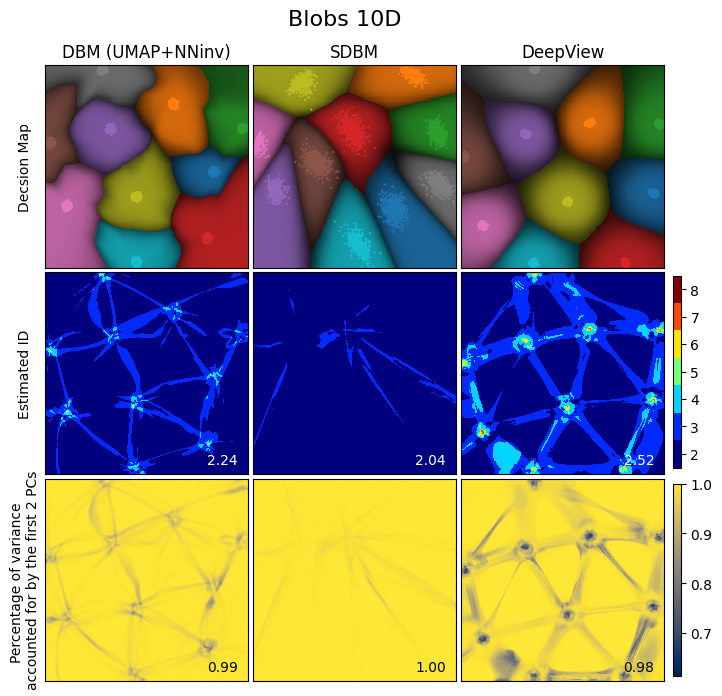

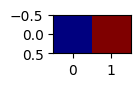

In [5]:
path = 'LID_results_new_grid500/blobs_dim10_n5000_y10_'
test = plot_LID2(path, threshold=0.99, title='Blobs 10D', mode1=mode)
# plt.tight_layout()

# test.savefig('figures/blobs_dim10_n5000_y10_.png', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim10_id.pdf', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim10_id.pdf', dpi=300, bbox_inches='tight')

tensor([[7.9016e-01, 2.0944e-01, 9.8381e-05,  ..., 1.0300e-05, 1.0285e-05,
         1.0261e-05],
        [7.6902e-01, 2.3057e-01, 9.3968e-05,  ..., 1.0725e-05, 1.0700e-05,
         1.0662e-05],
        [7.7989e-01, 2.1971e-01, 9.1018e-05,  ..., 1.0585e-05, 1.0583e-05,
         1.0525e-05],
        ...,
        [7.8864e-01, 2.1060e-01, 1.5199e-04,  ..., 2.1507e-05, 2.1470e-05,
         2.1448e-05],
        [7.9153e-01, 2.0773e-01, 1.3291e-04,  ..., 2.1340e-05, 2.1339e-05,
         2.1284e-05],
        [7.8279e-01, 2.1650e-01, 1.1082e-04,  ..., 2.1564e-05, 2.1561e-05,
         2.1507e-05]])
tensor([[7.5742e-01, 2.4080e-01, 3.4134e-04,  ..., 4.5424e-05, 4.5420e-05,
         4.5417e-05],
        [7.4772e-01, 2.5049e-01, 3.1484e-04,  ..., 4.6157e-05, 4.6150e-05,
         4.6129e-05],
        [7.3386e-01, 2.6429e-01, 3.6346e-04,  ..., 4.7357e-05, 4.7355e-05,
         4.7349e-05],
        ...,
        [7.3926e-01, 2.5265e-01, 6.0638e-03,  ..., 6.0481e-05, 6.0454e-05,
         6.0453e-05],
   

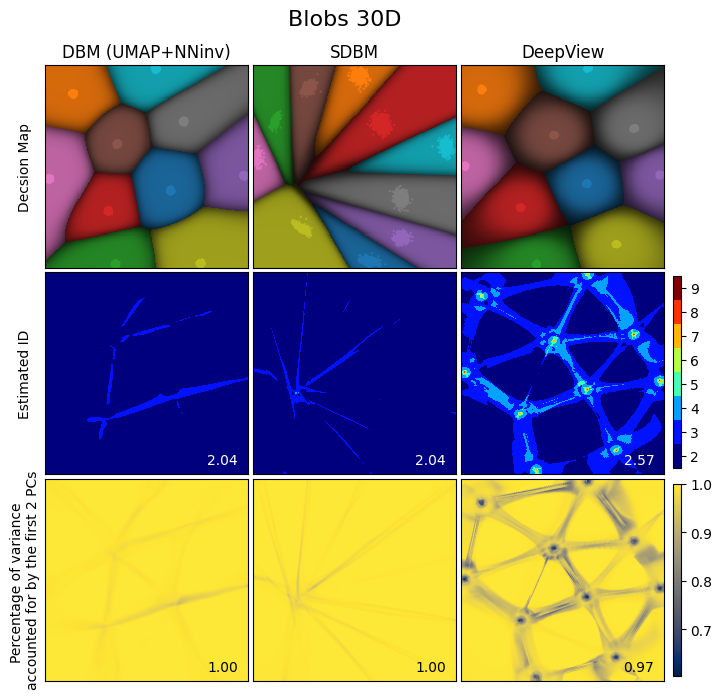

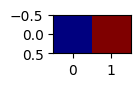

In [6]:
path = 'LID_results_new_grid500/blobs_dim30_n5000_y10_'
test = plot_LID2(path, threshold=0.99, title='Blobs 30D', mode1=mode)
# plt.tight_layout()
test.savefig('figures/blobs_dim30_n5000_y10_.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim30_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim30_id.pdf', dpi=300, bbox_inches='tight')

tensor([[7.6641e-01, 2.2880e-01, 1.1045e-03,  ..., 3.6763e-05, 3.6763e-05,
         3.6761e-05],
        [7.7204e-01, 2.2354e-01, 9.0222e-04,  ..., 3.5185e-05, 3.5184e-05,
         3.5073e-05],
        [7.5923e-01, 2.3652e-01, 8.4143e-04,  ..., 3.4066e-05, 3.4066e-05,
         3.4025e-05],
        ...,
        [7.7776e-01, 2.2174e-01, 4.3755e-05,  ..., 4.5291e-06, 4.5235e-06,
         4.5108e-06],
        [7.7294e-01, 2.2654e-01, 4.9744e-05,  ..., 4.6221e-06, 4.6179e-06,
         4.5846e-06],
        [7.7947e-01, 2.2001e-01, 5.0767e-05,  ..., 4.6495e-06, 4.6378e-06,
         4.5835e-06]])
tensor([[7.8770e-01, 2.1178e-01, 6.1267e-05,  ..., 4.1442e-06, 4.1441e-06,
         4.1437e-06],
        [7.7538e-01, 2.2407e-01, 7.5713e-05,  ..., 4.1905e-06, 4.1902e-06,
         4.1895e-06],
        [7.5321e-01, 2.4622e-01, 8.8047e-05,  ..., 4.2601e-06, 4.2474e-06,
         4.2387e-06],
        ...,
        [7.6559e-01, 2.3380e-01, 3.3321e-05,  ..., 5.3915e-06, 5.3914e-06,
         5.3898e-06],
   

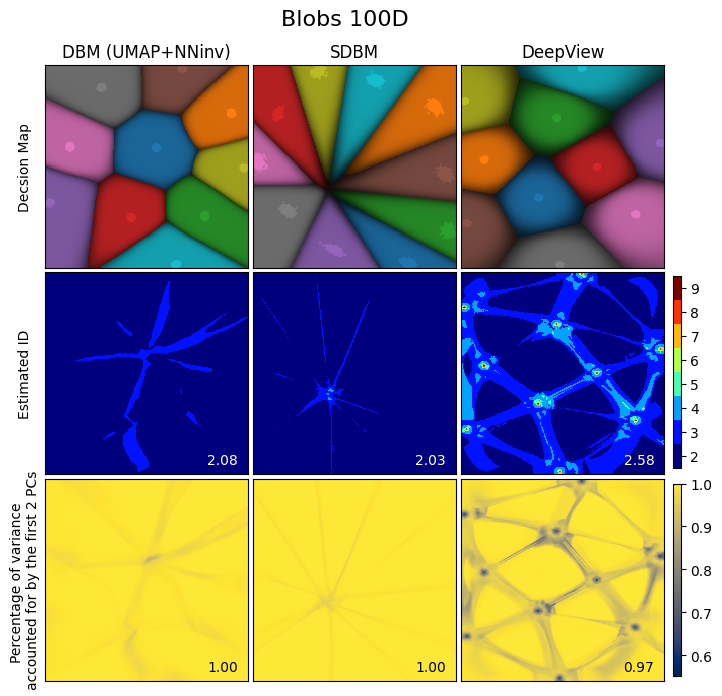

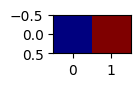

In [7]:
path = 'LID_results_new_grid500/blobs_dim100_n5000_y10_'
test = plot_LID2(path, threshold=0.99, title='Blobs 100D', mode1=mode)
# plt.tight_layout()
test.savefig('figures/blobs_dim100_n5000_y10_.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim100_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/PAPER_intrinsic_dim/figures/blobs_dim100_id.pdf', dpi=300, bbox_inches='tight')

tensor([[7.8094e-01, 2.1521e-01, 2.5181e-03,  ..., 1.7666e-07, 1.4037e-07,
         1.3672e-07],
        [7.6868e-01, 2.2749e-01, 2.4789e-03,  ..., 1.9527e-07, 1.9109e-07,
         1.8721e-07],
        [7.5669e-01, 2.3960e-01, 2.3147e-03,  ..., 1.8447e-07, 1.7903e-07,
         1.6264e-07],
        ...,
        [7.5963e-01, 2.3889e-01, 6.7619e-04,  ..., 7.3799e-07, 7.1919e-07,
         7.1205e-07],
        [7.7241e-01, 2.2611e-01, 6.5972e-04,  ..., 7.4723e-07, 7.3403e-07,
         7.3307e-07],
        [7.6654e-01, 2.3199e-01, 5.2737e-04,  ..., 7.4248e-07, 7.3942e-07,
         7.3923e-07]])
tensor([[7.7721e-01, 2.2156e-01, 1.0014e-04,  ..., 1.2003e-06, 1.1959e-06,
         1.1886e-06],
        [7.7350e-01, 2.2528e-01, 9.9356e-05,  ..., 1.1715e-06, 1.1583e-06,
         1.1495e-06],
        [7.6670e-01, 2.3207e-01, 9.9796e-05,  ..., 1.1802e-06, 1.1765e-06,
         1.1707e-06],
        ...,
        [7.6537e-01, 2.3293e-01, 4.1031e-04,  ..., 1.4228e-06, 1.3989e-06,
         1.3861e-06],
   

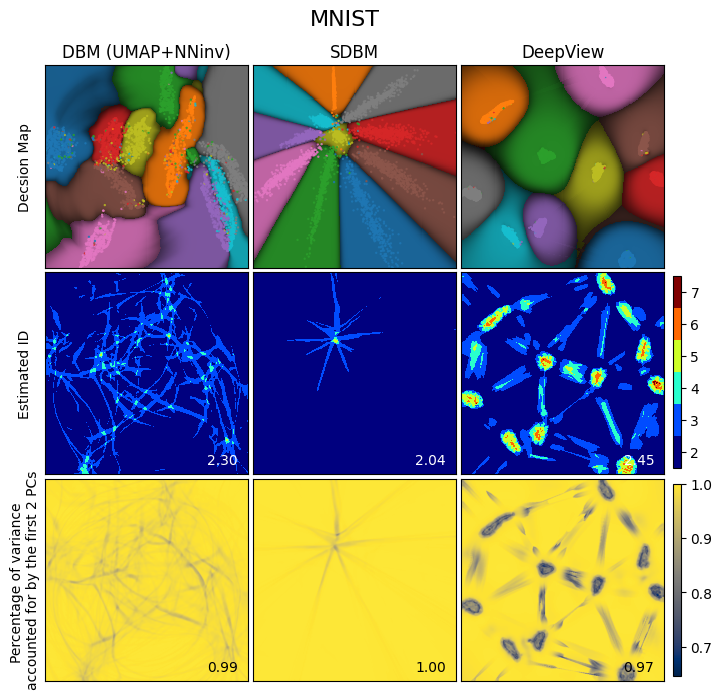

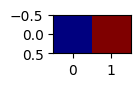

In [8]:
path = './LID_results_new_grid500/mnist_'
test = plot_LID2(path, threshold=0.99, title='MNIST', mode1=mode)
# plt.tight_layout()
# test.savefig('figures/mnist_minimal_var.png', dpi=300, bbox_inches='tight')
# test.savefig('../paper/PAPER_intrinsic_dim/figures/mnist_id.pdf', dpi=300, bbox_inches='tight')
if save:
    test.savefig('../paper/PAPER_intrinsic_dim/figures/mnist_id.pdf', dpi=300, bbox_inches='tight')



tensor([[7.6239e-01, 2.3382e-01, 2.5938e-03,  ..., 1.7411e-06, 1.7235e-06,
         1.6872e-06],
        [7.4388e-01, 2.5238e-01, 2.5193e-03,  ..., 1.7987e-06, 1.7868e-06,
         1.7788e-06],
        [7.3675e-01, 2.5965e-01, 2.3691e-03,  ..., 1.7768e-06, 1.7755e-06,
         1.6933e-06],
        ...,
        [7.5464e-01, 2.4332e-01, 1.1730e-03,  ..., 1.0169e-06, 1.0106e-06,
         9.8988e-07],
        [7.2322e-01, 2.7403e-01, 1.1525e-03,  ..., 1.0647e-06, 1.0608e-06,
         1.0431e-06],
        [7.0257e-01, 2.9034e-01, 5.0974e-03,  ..., 1.1012e-06, 1.0995e-06,
         1.0601e-06]])
tensor([[7.8917e-01, 2.0867e-01, 5.4479e-05,  ..., 3.4907e-06, 3.4882e-06,
         3.4371e-06],
        [7.6537e-01, 2.3238e-01, 6.8145e-05,  ..., 3.6029e-06, 3.5932e-06,
         3.5655e-06],
        [7.5456e-01, 2.4308e-01, 1.1433e-04,  ..., 3.6941e-06, 3.6932e-06,
         3.6894e-06],
        ...,
        [7.5660e-01, 2.4029e-01, 5.8611e-04,  ..., 4.2423e-06, 4.2407e-06,
         4.2260e-06],
   

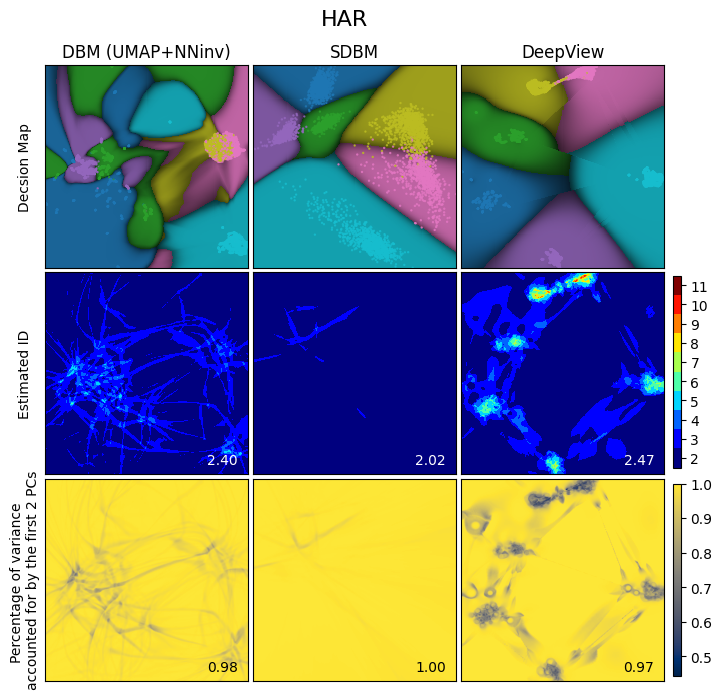

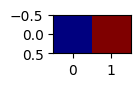

In [9]:
dim5 = plot_LID2('./LID_results_new_grid500/har_', threshold=0.99, title='HAR', mode1=mode)
# dim5.savefig('./figures/har_500bad.png', dpi=300, bbox_inches='tight')
# dim5.savefig('../paper/PAPER_intrinsic_dim/figures/har_id.pdf', dpi=300, bbox_inches='tight')
if save:
    dim5.savefig('../paper/PAPER_intrinsic_dim/figures/har_id.pdf', dpi=300, bbox_inches='tight')

In [37]:
## make the above 5 into a list 



### OLD

In [ ]:
dim50 = plot_LID('./LID_results/blobs_dim50_n1000_', threshold=0.99, title='50D Blobs')
dim50.savefig('./figures/blobs_dim50_n1000_.png', dpi=300, bbox_inches='tight')

NameError: name 'plot_LID' is not defined

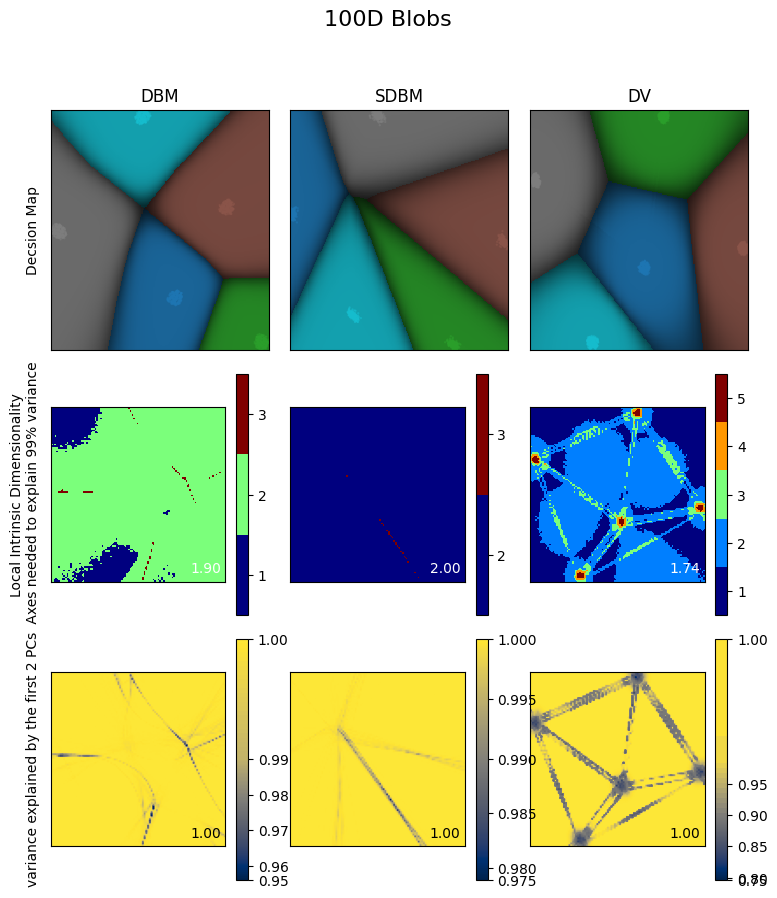

In [ ]:
dim100 = plot_LID('./LID_results/blobs_dim100_n1000_', threshold=0.99, title='100D Blobs')
dim100.savefig('./figures/blobs_dim100_n1000_.png', dpi=300)

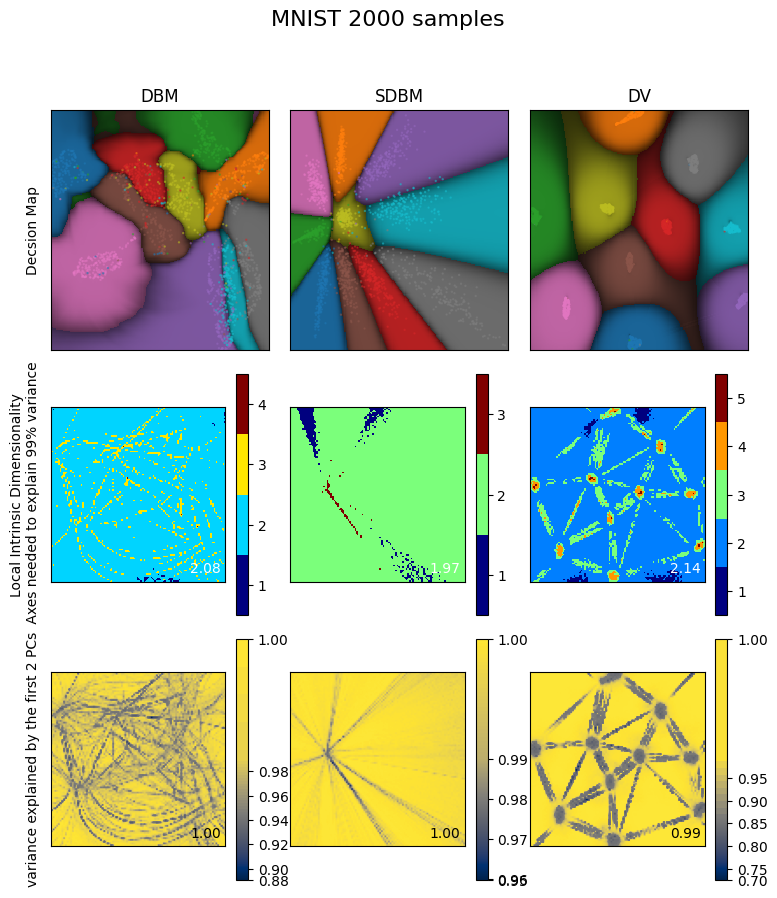

In [ ]:
mnist = plot_LID('./LID_results/mnist_', threshold=0.99, title='MNIST 2000 samples')
mnist.savefig('./figures/mnist.png', dpi=300)

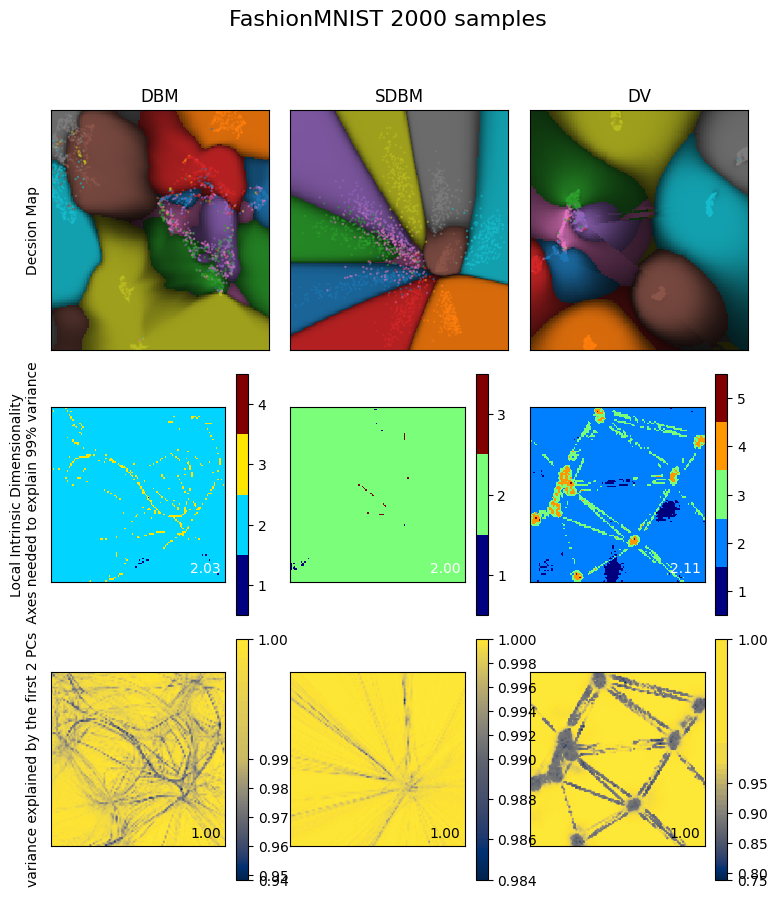

In [ ]:
mnist = plot_LID('./LID_results/fashionmnist_', threshold=0.99, title='FashionMNIST 2000 samples')
mnist.savefig('./figures/fashionmnist.png', dpi=300)

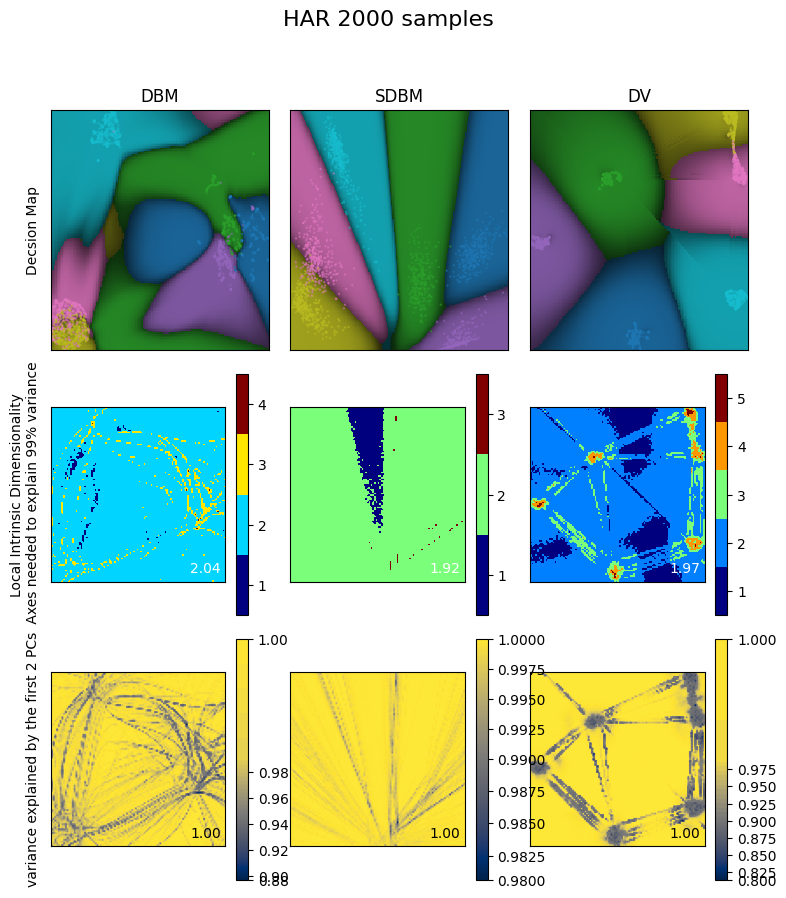

In [ ]:
mnist = plot_LID('./LID_results/har_', threshold=0.99, title='HAR 2000 samples')
mnist.savefig('./figures/har.png', dpi=300)